In [ ]:
!pip install bz2file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bz2file: filename=bz2file-0.98-py3-none-any.whl size=6881 sha256=7c73f250e8a768f26b309b0486a449734d51b444e891707d4cc27cde89b2971b
  Stored in directory: /root/.cache/pip/wheels/69/ee/f7/6fccd10cb65421ba2da64fa6caf8ee7fbae0059884af8c8587
Successfully built bz2file


In [ ]:
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# --------------------
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
# --------------------
from pandas import DataFrame as df
# --------------------
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# --------------------
import tarfile
import pickle
import random
import keras
import sys
import gc
import bz2file as bz2
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!tar -xvf /content/drive/MyDrive/RML2016.10b.bz2 -C /content/drive/MyDrive/

RML2016.10b.dat
LICENSE.TXT


In [ ]:
file = open("/content/drive/MyDrive/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Create Features Space

In [ ]:
features = {}

**Raw Time Feature**

In [ ]:
features['raw']        = X[:,0], X[:,1]

**First derivative in time**

In [ ]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

**Integral in time**

In [ ]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

**All Togetheer Feature Space**

In [ ]:
def extract_features(*arguments):
    
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    
    return np.stack(desired, axis = 1)

## Train and Test Data Split

** features Choice **

In [ ]:
data = extract_features('raw')
labels = np.array(lbl)

In [ ]:
in_shape = data[0].shape
out_shape = tuple([1]) + in_shape

** data shuffling & splitting **

In [ ]:
np.random.seed(10)

n_examples = labels.shape[0]

r = np.random.choice(range(n_examples), n_examples, replace = False)

train_examples = r[:n_examples//2]
test_examples =  r[n_examples//2:]

In [ ]:
X_train = data[train_examples]
X_test = data[test_examples]

y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

## Model for Fully Connected Nueral Networks

In [ ]:
model = Sequential()
model.add(Dense(128, activation ='relu', input_shape = in_shape))
model.add(Dense(256, activation ='relu'))
model.add(Dense(128, activation ='relu'))
model.add(Flatten())
model.add(Dense(10, activation ='softmax'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 128)            16512     
                                                                 
 dense_1 (Dense)             (None, 2, 256)            33024     
                                                                 
 dense_2 (Dense)             (None, 2, 128)            32896     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 85,002
Trainable params: 85,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs = 100, validation_split = 0.05, batch_size = 2048, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Epoch 1/100
279/279 [==============================] - 12s 13ms/step - loss: 1.9630 - accuracy: 0.2356 - val_loss: 1.7395 - val_accuracy: 0.3103
Epoch 2/100
279/279 [==============================] - 2s 7ms/step - loss: 1.6902 - accuracy: 0.3247 - val_loss: 1.6235 - val_accuracy: 0.3497
Epoch 3/100
279/279 [==============================] - 2s 6ms/step - loss: 1.6045 - accuracy: 0.3545 - val_loss: 1.5605 - val_accuracy: 0.3725
Epoch 4/100
279/279 [==============================] - 2s 7ms/step - loss: 1.5593 - accuracy: 0.3722 - val_loss: 1.5258 - val_accuracy: 0.3878
Epoch 5/100
279/279 [==============================] - 2s 7ms/step - loss: 1.5298 - accuracy: 0.3817 - val_loss: 1.5029 - val_accuracy: 0.3892
Epoch 6/100
279/279 [==============================] - 2s 6ms/step - loss: 1.5102 - accuracy: 0.3883 - val_loss: 1.4901 - val_accuracy: 0.3983
Epoch 7/100
279/279 [==============================] - 2s 8ms/step - loss: 1.4982 - accuracy: 0.3910 - val_loss: 1.4816 - val_accuracy: 0.39

In [ ]:
model.save('ann.h5')

## "AbRo" Model for Convolution Connected Neural Networks

In [ ]:
dr = 0.5
model = Sequential()
model.add(Reshape(out_shape, input_shape = in_shape))
model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
model.add(Dropout(dr))
model.add(Flatten())   
model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
model.add(Dropout(dr))
model.add(Dense(10, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
model.add(Reshape([len(mods)]))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 2, 132)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 256, 2, 130)       1024      
                                                                 
 dropout (Dropout)           (None, 256, 2, 130)       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 256, 2, 134)      0         
 ng2D)                                                           
                                                                 
 conv3 (Conv2D)              (None, 80, 1, 132)       

In [ ]:
model.fit(X_train, y_train, epochs = 100, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Epoch 1/100
557/557 [==============================] - 68s 92ms/step - loss: 1.7821 - accuracy: 0.2930 - val_loss: 1.3937 - val_accuracy: 0.4371
Epoch 2/100
557/557 [==============================] - 50s 89ms/step - loss: 1.3733 - accuracy: 0.4325 - val_loss: 1.2121 - val_accuracy: 0.4980
Epoch 3/100
557/557 [==============================] - 49s 88ms/step - loss: 1.3063 - accuracy: 0.4546 - val_loss: 1.2092 - val_accuracy: 0.4892
Epoch 4/100
557/557 [==============================] - 49s 88ms/step - loss: 1.2812 - accuracy: 0.4617 - val_loss: 1.1701 - val_accuracy: 0.5072
Epoch 5/100
557/557 [==============================] - 49s 88ms/step - loss: 1.2658 - accuracy: 0.4666 - val_loss: 1.1555 - val_accuracy: 0.5085
Epoch 6/100
557/557 [==============================] - 49s 88ms/step - loss: 1.2550 - accuracy: 0.4705 - val_loss: 1.1534 - val_accuracy: 0.5105
Epoch 7/100
557/557 [==============================] - 50s 89ms/step - loss: 1.2468 - accuracy: 0.4735 - val_loss: 1.1485 - val_ac

In [ ]:
model.save("cnn.h5")

## Evaluation

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

##**Fully Connected Neural Network Evaluation**

In [ ]:
ann_model = keras.models.load_model('/content/drive/MyDrive/ann.h5')

In [ ]:
y_pred_ann = ann_model.predict(X_test)

18750/18750 [==============================] - 37s 2ms/step


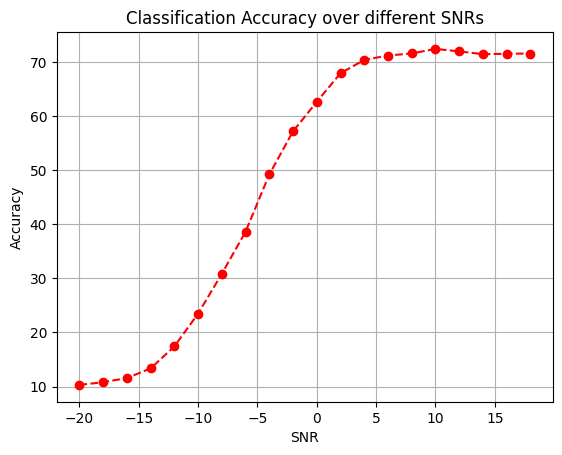

In [ ]:
plot_results(y_pred_ann, y_test, snr_test)

In [ ]:
print_results(y_pred_ann, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.3,10.81,11.57,13.36,17.42,23.5,30.86,38.65,49.23,57.21,62.68,67.96,70.42,71.24,71.62,72.46,72.0,71.49,71.56,71.61


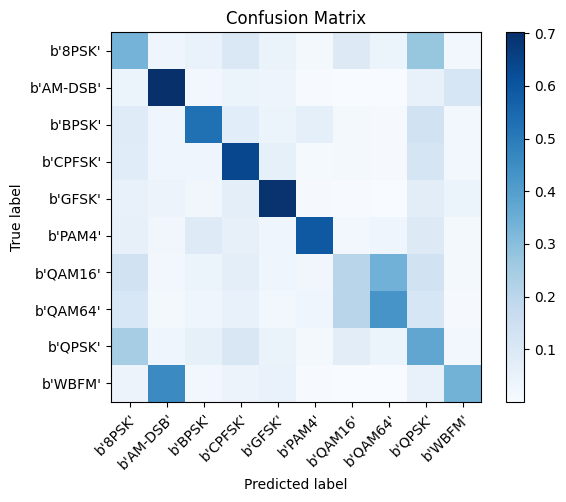

In [ ]:
plot_confusion_matrix(y_test, y_pred_ann, mods)

#Convolutional Neural Network Evaluation

In [ ]:
cnn_model = keras.models.load_model('/content/drive/MyDrive/cnn.h5')

In [ ]:
y_pred_cnn = cnn_model.predict(X_test)

18750/18750 [==============================] - 42s 2ms/step


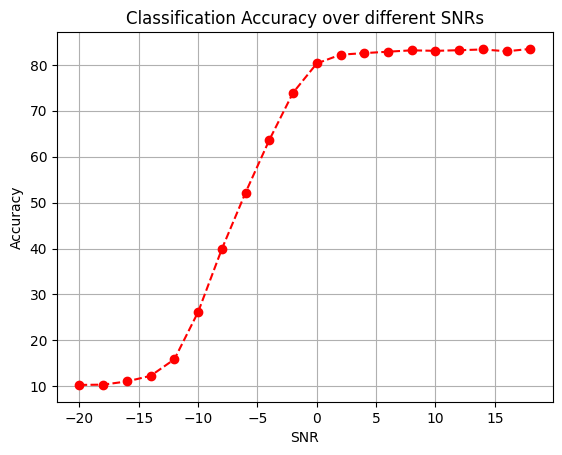

In [ ]:
plot_results(y_pred_cnn, y_test, snr_test)

In [ ]:
print_results(y_pred_cnn, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.31,10.37,11.07,12.29,15.89,26.18,39.9,52.19,63.64,73.92,80.3,82.22,82.55,82.87,83.16,83.05,83.19,83.35,82.96,83.47


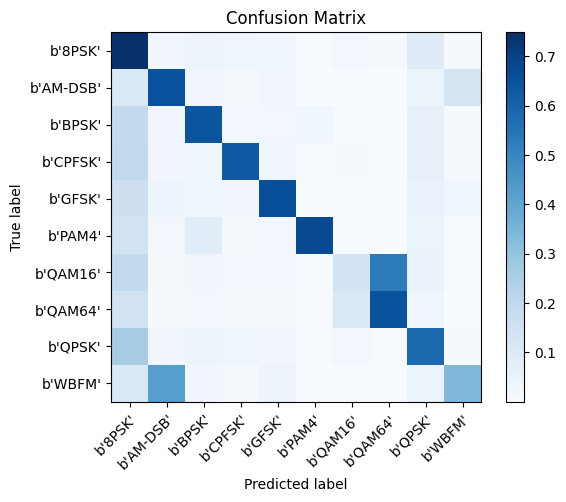

In [ ]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)

In [ ]:
def train_once(size = 5000):
  dr = 0.5
  model = Sequential()
  model.add(Reshape(out_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
  model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
  model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
  model.add(Dropout(dr))
  model.add(Flatten())   
  model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
  model.add(Dropout(dr))
  model.add(Dense(10, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
  model.add(Reshape([len(mods)]))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  #model.summary()
  model.fit(X_train[:size], y_train[:size], epochs = 100, batch_size = 1024, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])
  train_pred = model.evaluate(X_train[:size], y_train[:size])
  test_pred = model.evaluate(X_test, y_test)
  return traind_pred, test_pred
  

In [ ]:
list(range(5000, 100000, 5000))

[5000,
 10000,
 15000,
 20000,
 25000,
 30000,
 35000,
 40000,
 45000,
 50000,
 55000,
 60000,
 65000,
 70000,
 75000,
 80000,
 85000,
 90000,
 95000]

In [ ]:
train_scores, test_scores = [], []
rang = range(5000, 100000, 5000)
for i in rang:
  trn, tst = train_once(i)
  train_scores.append(trn)
  test_scores.append(tst)

plt.imshow(rang, train_scores, 'ro--', rang, test_scores, 'bo--')